In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import pdist, cdist, squareform, directed_hausdorff
import sklearn

import procrustes

import kmapper as km

from scipy import stats

import json

In [2]:
# from kmapper.plotlyviz import plotlyviz
# from kmapper.plotlyviz import *
# import plotly.graph_objs as go

In [3]:
# # modify node size function to make differences more exaggerated
# from kmapper import visuals

# def _size_node(member_ids):
#     return int(2*np.sqrt(len(member_ids)))

# visuals._size_node = _size_node

In [4]:
def flatten(regular_list):
    flat_list = [item for sublist in regular_list for item in sublist]
    
    return flat_list

In [5]:
# read only the first 1000 rows since doing procrustes on the whole data set takes a while
mdata = pd.read_csv('passiflora.csv')
mdata['heteroblasty'] = mdata['ontogeny'] / mdata['total']
mdata = mdata[:1000]

In [6]:
# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':7,
 'amethystina':4,
 'alata':6,
 'rubra':2,
 'misera':1,
 'setacea':3,
 'triloba':5,
 'nitida':6,
 'actinia':5,
 'villosa':6,
 'micropetala':2,
 'mucronata':7,
 'maliformis':7,
 'miersii':5,
 'malacophylla':7,
 'gibertii':3,
 'mollissima':3,
 'caerulea':3,
 'gracilis':4,
 'foetida':4,
 'racemosa':6,
 'tenuifila':3,
 'cristalina':7,
 'ligularis':6,
 'cincinnata':3,
 'coccinea':7,
 'hatschbachii':3,
 'morifolia':4,
 'organensis':2,
 'capsularis':2,
 'edmundoi':3,
 'galbana':7,
 'tricuspis':2,
 'pohlii':2,
 'biflora':2,
 'sidifolia':5,
 'suberosa':3,
 'edulis':6,
 'coriacea':1,
 'kermesina':3}

In [7]:
mdata = mdata.replace(species_classes)

# Procrustes alignment of landmark data

In [8]:
def get_landmarks(df):
    xs = df.filter(regex="^x[0-9]+").to_numpy()
    ys = df.filter(regex="^y[0-9]+").to_numpy()
    lmks = np.stack((xs, ys), axis=2)
    
    centroids = procrustes.get_position(lmks)
    lmks_centered = procrustes.remove_position(lmks)

    scale_factors = procrustes.get_scale(lmks_centered)
    lmks_scaled = procrustes.remove_scale(lmks_centered)

    res_gpa = procrustes.gpa(lmks_scaled)
    lmk_mean = res_gpa['mean']

    lmk_pts = {'original': lmks,
               'centered': lmks_centered,
               'scaled': lmks_scaled,
               'aligned': res_gpa['aligned']
               }
    props = {'centroids': centroids,
             'scale_factors': scale_factors
             }

    return(lmk_pts, lmk_mean, props)

In [9]:
# use this cell instead of the next if doing a mapper for each species

# lmk_pts = {}
# lmk_mean = {}
# props = {}

# for i in range(0, len(species)):
#     lmk_pts[i], lmk_mean[i], props[i] = get_landmarks(mdata[mdata['species'] == i])

In [10]:
lmk_pts, lmk_mean, props = get_landmarks(mdata)

ssq diff 2.842170943040401e-14


# Plot aligned leaf and average shape

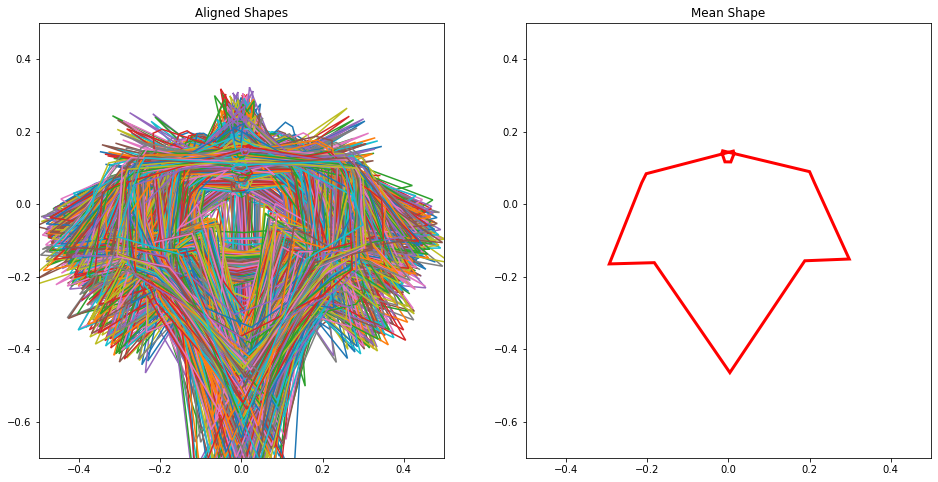

In [11]:
from matplotlib.patches import Polygon

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for ax in axs:
    ax.set_xlim(left=-0.5, right=0.5)
    ax.set_ylim(bottom=-0.7, top=0.5)

for i in range(lmk_pts['scaled'].shape[0]):
    col = colors[i % len(colors)]

    pa_xy = lmk_pts['aligned'][i]
    pa = Polygon(pa_xy, edgecolor=col, facecolor='none', linewidth=1.5)
    axs[0].add_patch(pa)
    axs[0].set_title('Aligned Shapes')

pm = Polygon(lmk_mean, edgecolor='red', facecolor='none', linewidth=3)
axs[1].add_patch(pm)
axs[1].set_title('Mean Shape')

plt.show()

# Compute leaf distances

### Correlation distance

In [12]:
landmark_matrix = np.array([flatten(list(lmk_pts['aligned'][i])) for i in range(0,len(mdata))])

In [13]:
distance_correlation = squareform(pdist(landmark_matrix, 'correlation'))

# Lenses

### Heteroblasty

In [14]:
heteroblasty_lens = np.array(mdata['heteroblasty'].tolist())

### Vein to blade

In [15]:
# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# landmarks in order to run shoestring algorithm
coords_area = [6, 15, 14, 13, 12, 11, 10, 9, 8, 7, 1]
coords_vein = [6, 15, 5, 13, 4, 11, 3, 9, 2, 7, 1]

In [16]:
leaf_areas = []
leaf_veins = []

# compute blade area
for j in lmk_pts['aligned']:
    x = np.array([j[i-1][0] for i in coords_area])
    y = np.array([j[i-1][1] for i in coords_area])
    leaf_areas.append(PolyArea(x,y))

# compute vein area
for j in lmk_pts['aligned']:
    x = np.array([j[i-1][0] for i in coords_vein])
    y = np.array([j[i-1][1] for i in coords_vein])
    leaf_veins.append(PolyArea(x,y))    

In [17]:
vtb_lens = np.array([i/j for i,j in zip(leaf_veins, leaf_areas)])

# KeplerMapper

Do not need to run this section if you are just doing pie chart mapper

In [18]:
colorscale_discrete7 = [[0.0,'#e41a1c'],
                       [1/6,'#377eb8'],
                       [2/6,'#4daf4a'],
                       [3/6,'#984ea3'],
                       [4/6,'#ff7f00'],
                       [5/6,'#ffff33'],
                       [1.0,'#a65628']]

In [19]:
labels = np.array(mdata['species'].tolist(), dtype = int)

In [20]:
mapper = km.KeplerMapper(verbose = 0)

graph = mapper.map(
    heteroblasty_lens,
    distance_correlation,
    cover = km.Cover(n_cubes = 13, perc_overlap = 0.5),
    # remember to change epsilon based on distance matrix
    clusterer = sklearn.cluster.DBSCAN(eps = 0.01, min_samples = 2, metric = 'precomputed'),
    precomputed = 'True')

html = mapper.visualize(
    graph,
    path_html = 'passiflora_test.html',
    color_values = [0.167*i for i in labels],
    color_function_name = 'test',
    node_color_function="mode",
    colorscale = colorscale_discrete7,
    title = 'passiflora mapper heteroblasty lens',
    nbins = 7)

# Pie chart mapper

In [21]:
# create a json dict to input into the mapper visualization

# class number = color number

json_dict = {"nodes": [], "links": []}

for i in graph['nodes']:
    testlist = mdata.loc[graph['nodes'][i]]['species'].tolist()
    
    n = {
        "id": i, # this is used for links
        "group": int(stats.mode(testlist)[0][0]), # this is the outer node color
        "node_size": len(mdata.loc[graph['nodes'][i]]),
        "pieChart": []
        }
        
    for j in set(testlist):
        n["pieChart"].append({"color":j, "percent":int(100*testlist.count(j)/len(testlist))})

    json_dict["nodes"].append(n)

# we need a double for loop since some link values are length > 1
for k in range(0, len(graph['links'])):
    for l in list(graph['links'].values())[k]:
        source = list(graph['links'].keys())[k]
        target = l
        value = len(set(mdata.loc[graph['nodes'][source]]['plant'].tolist()) & set(mdata.loc[graph['nodes'][target]]['plant'].tolist()))
        json_dict["links"].append({"source": source, "target": target, "value": value})
        
with open('passiflora_pie_graph/data.json', 'w') as outfile:
    json.dump(json_dict, outfile)